In [41]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import graphviz

In [24]:
data_raw = pd.read_csv('nshap_w1_w2_w3_core_disposition.csv',
                       low_memory=False)

## Data cleaning

In [25]:
# Since the data contains original cohort and follow-up cohort, we need to filter out the follow-up cohort
print("Total observations: {}".format(len(data_raw)))
data_w1 = data_raw[~data_raw['w1WEIGHT_ADJ'].isnull()]
print("Removed follow-up {} respondents without W1 observations".format(len(data_raw) - len(data_w1)))
data_decease= data_w1[data_w1.notnull()].copy()
data_decease['deceased'] = data_decease['w3DECEASED']
data_decease[data_decease['deceased'] == 'Unknown'] = np.nan
data_decease['deceased'].fillna(data_decease['w2DECEASED'], inplace=True)
data_decease[data_decease['deceased'] == 'Unknown'] = np.nan
data_complete = data_decease[data_decease['deceased'].notnull()]
print("Removed follow-up {} respondents without disposition statuses".format(len(data_w1) - len(data_complete)))
print("Sample frame has {} respondents".format(len(data_complete)))
# data_w3_missing = data_w1.iloc[(data_w1['w3DECEASED'] == 'Unknown').values]
# data_w3_missing = data_w3_missing.assign(deceased=data_w3_missing['w2DECEASED'])
# data_w3_nona = data_w1[(data_w1['w3DECEASED'] != 'Unknown').values]
# data_w3_nona = data_w3_nona.assign(deceased=data_w3_nona['w3DECEASED'])
# data_complete = pd.concat([data_w3_missing, data_w3_nona])

Total observations: 6069
Removed follow-up 3064 respondents without W1 observations
Removed follow-up 0 respondents without disposition statuses
Sample frame has 3005 respondents


In [26]:
data_complete['deceased'].value_counts()

 0.0    2062
 1.0     893
-9.0      50
Name: deceased, dtype: int64

In [27]:
data = data_complete[['ID','deceased', 'w1AGE', 'w1SYSTOLIC_MEAN',
                      'w1BMI', 'w1HBA1C', 'w1CRP', 'w1DHEA_1', 'w1DHEA_2',
                      'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                      'w1EDUC', 'w1HSASSETS_RECODE', 'w1MARITLST', 'w1ETHGRP',
                      'w1GENDER',
                      'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]


In [28]:
cat_col = ['ID', 'deceased', 'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT',
           'w1EDUC', 'w1HSASSETS_RECODE', 'w1MARITLST', 'w1ETHGRP', 'w1GENDER',
           'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']
data_cat = data[data[cat_col].notnull()].copy()[cat_col]    
for col in cat_col:
    data_cat[col] = data_cat[col].astype('category')
data_cat['w1married'] = np.where(data_cat['w1MARITLST'] == 'Married', 1, 0)
data_cat.drop('w1MARITLST', axis=1, inplace=True)

In [29]:
ord_col = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C', 
           'w1CRP', 'w1DHEA_1', 'w1DHEA_2', 'w1HRSSLEEP']
data_ord = data[data[ord_col].notnull()].copy()[ord_col]    
for col in ord_col:
    data_ord[col] = pd.to_numeric(data_ord[col], errors='coerce')
data_ord['w1dhea_mean'] = data_ord[['w1DHEA_1', 'w1DHEA_2']].mean(axis=1)
data_ord = data_ord.drop(['w1DHEA_1', 'w1DHEA_2'], axis=1)
data_ord[data_ord < 0] = np.nan
data_ord.describe()

,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,w1dhea_mean
count,3005.000000,2935.000000,2790.000000,1746.000000,1939.000000,2984.000000,2396.000000
mean,69.302163,137.142646,29.100726,6.096907,3.199975,6.886394,53.038773
std,7.853384,20.550247,6.322762,1.025504,6.033221,1.387953,122.967520
min,57.000000,78.000000,14.063041,4.200000,0.000000,1.000000,1.510000
25%,62.000000,122.500000,24.821613,5.500000,0.633500,6.000000,18.540000
50%,69.000000,135.000000,28.235349,5.800000,1.531000,7.000000,34.900000
75%,76.000000,149.500000,32.147006,6.300000,3.545000,8.000000,64.217500
max,85.000000,233.000000,75.600655,14.200000,100.000000,13.000000,5000.000000


In [31]:
data = pd.concat([data_cat, data_ord], axis=1)

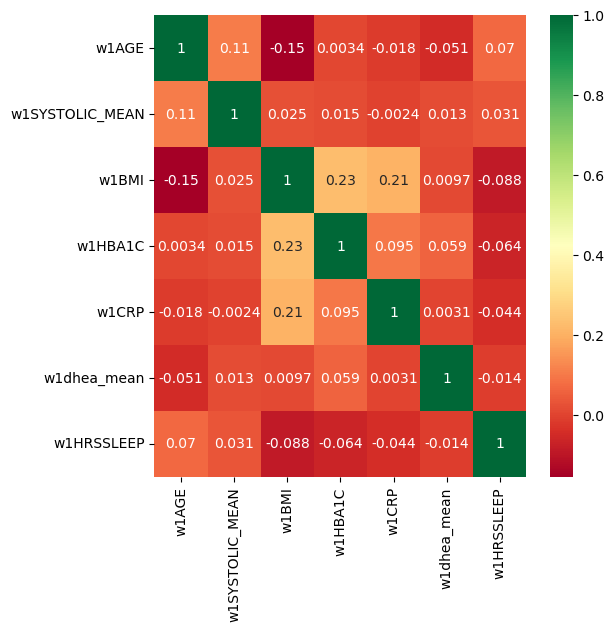

In [32]:
_, ax = plt.subplots(figsize=(6,6))
columns = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C', 
           'w1CRP', 'w1dhea_mean', 'w1HRSSLEEP']
sns.heatmap(data[columns].corr(),annot=True,cmap='RdYlGn', ax=ax);

In [11]:
# BOTH PRE-PRUNING AND POST_PRUNING (PYTHON PACKAGES TO AUTOMATE THIS PROCESS)
# DATASET SPLITTING
#E.g., 60% train, 20% validation, 20% test

## Decision Tree

In [42]:
data_nona = data.dropna()

data_x = data_nona[['w1AGE', 'w1SYSTOLIC_MEAN',
                      'w1BMI', 'w1HBA1C', 'w1CRP', 'w1dhea_mean',
                      'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                      'w1EDUC', 'w1HSASSETS_RECODE', 'w1married', 'w1ETHGRP',
                      'w1GENDER',
                      'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]
data_y = data_nona[['deceased']]

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42)
 # 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=1)

In [43]:
DT_clf = tree.DecisionTreeClassifier(random_state=42, criterion="entropy", 
                                     min_impurity_decrease=0.01)
DT_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.01,
                       random_state=42)

In [44]:
# save tree to iris.pdf
dot_data = tree.export_graphviz(DT_clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree_nshap") 

'tree_nshap.pdf'